In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_curve,roc_auc_score

In [2]:
from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    './My Project 18021-e0a14e0a0015.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

In [4]:
miner_limit = 5000
non_miner_limit = 50000

In [5]:
sql='''
WITH 
output_ages AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_ages_address,
    MIN(block_timestamp_month) AS output_month_min,
    MAX(block_timestamp_month) AS output_month_max
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  GROUP BY output_ages_address
)
,input_ages AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_ages_address,
    MIN(block_timestamp_month) AS input_month_min,
    MAX(block_timestamp_month) AS input_month_max
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
  GROUP BY input_ages_address
)
,output_monthly_stats AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_monthly_stats_address, 
    COUNT(DISTINCT block_timestamp_month) AS output_active_months,
    COUNT(outputs) AS total_tx_output_count,
    SUM(value) AS total_tx_output_value,
    AVG(value) AS mean_tx_output_value,
    STDDEV(value) AS stddev_tx_output_value,
    COUNT(DISTINCT(`hash`)) AS total_output_tx,
    SUM(value)/COUNT(block_timestamp_month) AS mean_monthly_output_value,
    COUNT(outputs.addresses)/COUNT(block_timestamp_month) AS mean_monthly_output_count
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  GROUP BY output_monthly_stats_address
)
,input_monthly_stats AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_monthly_stats_address, 
    COUNT(DISTINCT block_timestamp_month) AS input_active_months,
    COUNT(inputs) AS total_tx_input_count,
    SUM(value) AS total_tx_input_value,
    AVG(value) AS mean_tx_input_value,
    STDDEV(value) AS stddev_tx_input_value,
    COUNT(DISTINCT(`hash`)) AS total_input_tx,
    SUM(value)/COUNT(block_timestamp_month) AS mean_monthly_input_value,
    COUNT(inputs.addresses)/COUNT(block_timestamp_month) AS mean_monthly_input_count
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
  GROUP BY input_monthly_stats_address
)
,output_idle_times AS (
  SELECT
    address AS idle_time_address,
    AVG(idle_time) AS mean_output_idle_time,
    STDDEV(idle_time) AS stddev_output_idle_time
  FROM
  (
    SELECT 
      event.address,
      IF(prev_block_time IS NULL, NULL, UNIX_SECONDS(block_time) - UNIX_SECONDS(prev_block_time)) AS idle_time
    FROM (
      SELECT
        ARRAY_TO_STRING(outputs.addresses,',') AS address, 
        block_timestamp AS block_time,
        LAG(block_timestamp) OVER (PARTITION BY ARRAY_TO_STRING(outputs.addresses,',') ORDER BY block_timestamp) AS prev_block_time
      FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
    ) AS event
    WHERE block_time != prev_block_time
  )
  GROUP BY address
)
,input_idle_times AS (
  SELECT
    address AS idle_time_address,
    AVG(idle_time) AS mean_input_idle_time,
    STDDEV(idle_time) AS stddev_input_idle_time
  FROM
  (
    SELECT 
      event.address,
      IF(prev_block_time IS NULL, NULL, UNIX_SECONDS(block_time) - UNIX_SECONDS(prev_block_time)) AS idle_time
    FROM (
      SELECT
        ARRAY_TO_STRING(inputs.addresses,',') AS address, 
        block_timestamp AS block_time,
        LAG(block_timestamp) OVER (PARTITION BY ARRAY_TO_STRING(inputs.addresses,',') ORDER BY block_timestamp) AS prev_block_time
      FROM `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(inputs) AS inputs
    ) AS event
    WHERE block_time != prev_block_time
  )
  GROUP BY address
)
--,miners AS (
--)

(SELECT
  TRUE AS is_miner,
  output_ages_address AS address,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_month_min,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) AS output_month_max,
  UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_month_min,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS input_month_max,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_active_time,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_active_time,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS io_max_lag,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS io_min_lag,
  output_monthly_stats.output_active_months,
  output_monthly_stats.total_tx_output_count,
  output_monthly_stats.total_tx_output_value,
  output_monthly_stats.mean_tx_output_value,
  output_monthly_stats.stddev_tx_output_value,
  output_monthly_stats.total_output_tx,
  output_monthly_stats.mean_monthly_output_value,
  output_monthly_stats.mean_monthly_output_count,
  input_monthly_stats.input_active_months,
  input_monthly_stats.total_tx_input_count,
  input_monthly_stats.total_tx_input_value,
  input_monthly_stats.mean_tx_input_value,
  input_monthly_stats.stddev_tx_input_value,
  input_monthly_stats.total_input_tx,
  input_monthly_stats.mean_monthly_input_value,
  input_monthly_stats.mean_monthly_input_count,
  output_idle_times.mean_output_idle_time,
  output_idle_times.stddev_output_idle_time,
  input_idle_times.mean_input_idle_time,
  input_idle_times.stddev_input_idle_time
FROM
  output_ages, output_monthly_stats, output_idle_times,
  input_ages,  input_monthly_stats, input_idle_times
WHERE TRUE
  AND output_ages.output_ages_address = output_monthly_stats.output_monthly_stats_address
  AND output_ages.output_ages_address = output_idle_times.idle_time_address
  AND output_ages.output_ages_address = input_monthly_stats.input_monthly_stats_address
  AND output_ages.output_ages_address = input_ages.input_ages_address
  AND output_ages.output_ages_address = input_idle_times.idle_time_address
  AND output_ages.output_ages_address IN
(
  SELECT 
    ARRAY_TO_STRING(outputs.addresses,',') AS miner
  FROM 
  `bigquery-public-data.crypto_bitcoin.blocks` AS blocks,
  `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  WHERE blocks.hash = transactions.block_hash 
    AND is_coinbase IS TRUE
    AND ( FALSE
      --
      -- miner signatures from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
      --
      OR coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' --AntPool
      OR coinbase_param LIKE '%2f42434d6f6e737465722f%' --BCMonster
      --BitcoinAffiliateNetwork
      OR coinbase_param LIKE '%4269744d696e746572%' --BitMinter
      --BTC.com
      --BTCC Pool
      --BTCDig
      OR coinbase_param LIKE '%2f7374726174756d2f%' --Btcmp
      --btcZPool.com
      --BW Mining
      OR coinbase_param LIKE '%456c6967697573%' --Eligius
      --F2Pool
      --GHash.IO
      --Give Me COINS
      --Golden Nonce Pool
      OR coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' --Bravo Mining
      OR coinbase_param LIKE '%4b616e6f%' --KanoPool
      --kmdPool.org
      OR coinbase_param LIKE '%2f6d6d706f6f6c%' --Merge Mining Pool
      --MergeMining
      --Multipool
      --P2Pool
      OR coinbase_param LIKE '%2f736c7573682f%' --Slush Pool
      --ZenPool.org
    )
  GROUP BY miner
  HAVING COUNT(1) >= 20 
)
LIMIT {})
UNION ALL
(SELECT
  FALSE AS is_miner,
  output_ages_address AS address,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_month_min,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) AS output_month_max,
  UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_month_min,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS input_month_max,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) AS output_active_time,
  UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS input_active_time,
  UNIX_SECONDS(CAST(output_ages.output_month_max AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_max AS TIMESTAMP)) AS io_max_lag,
  UNIX_SECONDS(CAST(output_ages.output_month_min AS TIMESTAMP)) - UNIX_SECONDS(CAST(input_ages.input_month_min AS TIMESTAMP)) AS io_min_lag,
  output_monthly_stats.output_active_months,
  output_monthly_stats.total_tx_output_count,
  output_monthly_stats.total_tx_output_value,
  output_monthly_stats.mean_tx_output_value,
  output_monthly_stats.stddev_tx_output_value,
  output_monthly_stats.total_output_tx,
  output_monthly_stats.mean_monthly_output_value,
  output_monthly_stats.mean_monthly_output_count,
  input_monthly_stats.input_active_months,
  input_monthly_stats.total_tx_input_count,
  input_monthly_stats.total_tx_input_value,
  input_monthly_stats.mean_tx_input_value,
  input_monthly_stats.stddev_tx_input_value,
  input_monthly_stats.total_input_tx,
  input_monthly_stats.mean_monthly_input_value,
  input_monthly_stats.mean_monthly_input_count,
  output_idle_times.mean_output_idle_time,
  output_idle_times.stddev_output_idle_time,
  input_idle_times.mean_input_idle_time,
  input_idle_times.stddev_input_idle_time
FROM
  output_ages, output_monthly_stats, output_idle_times,
  input_ages,  input_monthly_stats, input_idle_times
WHERE TRUE
  AND output_ages.output_ages_address = output_monthly_stats.output_monthly_stats_address
  AND output_ages.output_ages_address = output_idle_times.idle_time_address
  AND output_ages.output_ages_address = input_monthly_stats.input_monthly_stats_address
  AND output_ages.output_ages_address = input_ages.input_ages_address
  AND output_ages.output_ages_address = input_idle_times.idle_time_address
  AND output_ages.output_ages_address NOT IN
(
  SELECT 
    ARRAY_TO_STRING(outputs.addresses,',') AS miner
  FROM 
  `bigquery-public-data.crypto_bitcoin.blocks` AS blocks,
  `bigquery-public-data.crypto_bitcoin.transactions` AS transactions JOIN UNNEST(outputs) AS outputs
  WHERE blocks.hash = transactions.block_hash 
    AND is_coinbase IS TRUE
    AND ( FALSE
      --
      -- miner signatures from https://en.bitcoin.it/wiki/Comparison_of_mining_pools
      --
      OR coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' --AntPool
      OR coinbase_param LIKE '%2f42434d6f6e737465722f%' --BCMonster
      --BitcoinAffiliateNetwork
      OR coinbase_param LIKE '%4269744d696e746572%' --BitMinter
      --BTC.com
      --BTCC Pool
      --BTCDig
      OR coinbase_param LIKE '%2f7374726174756d2f%' --Btcmp
      --btcZPool.com
      --BW Mining
      OR coinbase_param LIKE '%456c6967697573%' --Eligius
      --F2Pool
      --GHash.IO
      --Give Me COINS
      --Golden Nonce Pool
      OR coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' --Bravo Mining
      OR coinbase_param LIKE '%4b616e6f%' --KanoPool
      --kmdPool.org
      OR coinbase_param LIKE '%2f6d6d706f6f6c%' --Merge Mining Pool
      --MergeMining
      --Multipool
      --P2Pool
      OR coinbase_param LIKE '%2f736c7573682f%' --Slush Pool
      --ZenPool.org
    )
  GROUP BY miner
  HAVING COUNT(1) >= 20 
)
LIMIT {})
'''.format(miner_limit, non_miner_limit)

In [6]:
data = client.query(sql).to_dataframe()

In [7]:
data.isnull().sum()

is_miner                         0
address                          0
output_month_min                 0
output_month_max                 0
input_month_min                  0
input_month_max                  0
output_active_time               0
input_active_time                0
io_max_lag                       0
io_min_lag                       0
output_active_months             0
total_tx_output_count            0
total_tx_output_value            0
mean_tx_output_value             0
stddev_tx_output_value           0
total_output_tx                  0
mean_monthly_output_value        0
mean_monthly_output_count        0
input_active_months              0
total_tx_input_count             0
total_tx_input_value             0
mean_tx_input_value              0
stddev_tx_input_value            0
total_input_tx                   0
mean_monthly_input_value         0
mean_monthly_input_count         0
mean_output_idle_time            0
stddev_output_idle_time      19032
mean_input_idle_time

In [10]:
drop_columns = ['stddev_output_idle_time','stddev_input_idle_time']
data.drop(drop_columns,axis=1,inplace=True)

In [11]:
X = data.drop(['is_miner','address'],axis=1)
y = data['is_miner']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [12]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
train_probs = rf.predict_proba(X_train)[:,1]
probs = rf.predict_proba(X_test)[:,1]
train_predictions = rf.predict(X_train)
predictions = rf.predict(X_test)

In [23]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5

    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)

    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
 
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); 
    plt.title('ROC Curves')

Recall Baseline: 1.0 Test: 0.97 Train: 1.0
Precision Baseline: 0.09 Test: 0.94 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


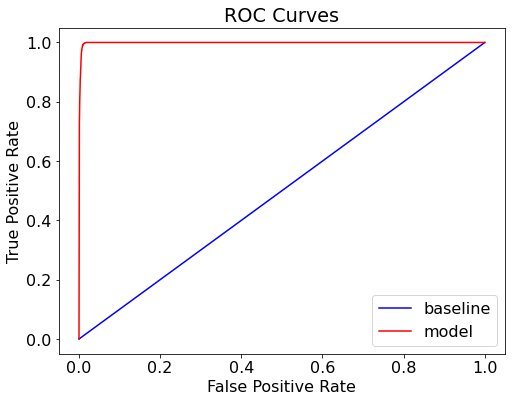

In [24]:
evaluate_model(predictions, probs, train_predictions, train_probs)

In [25]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 20)
    plt.yticks(tick_marks, classes, size = 20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 30,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 20)
    plt.xlabel('Predicted label', size = 20)

Confusion matrix, without normalization
[[16392   109]
 [   43  1606]]


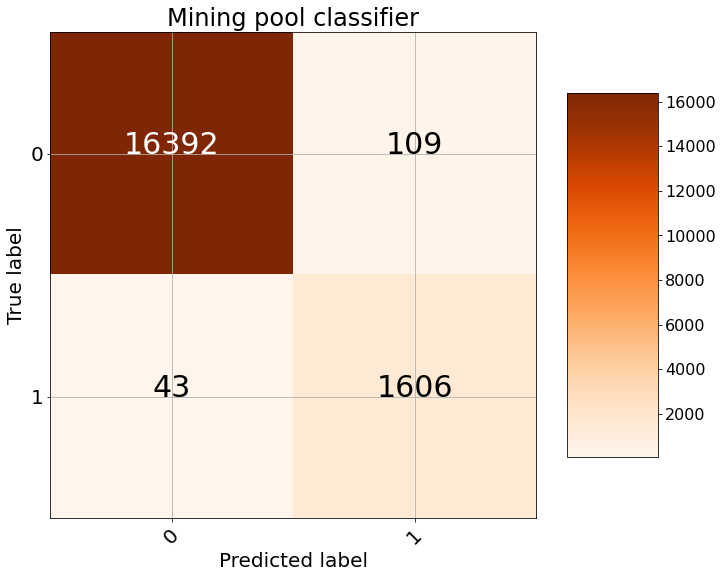

In [28]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['0','1'],
                      title = 'Mining pool classifier')